# Miniproject 2

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [46]:
def clean_data(movies_file, data_file):
    unique_title_id_map = {}  # to keep track of titles that already have an id
    needed_updates = {}  # this array will map ids that need to be changed to the id
    # they should be changed to
    with open(movies_file, 'r') as f:
        for line in f:
            line_data = line.strip('\n').split('\t')
            movie_id, title = line_data[0], line_data[1]
            if str(title) in unique_title_id_map:
                needed_updates[movie_id] = unique_title_id_map[str(title)]
            else:
                unique_title_id_map[str(title)] = str(movie_id)
    # print(needed_updates)

    data_arr = np.loadtxt(data_file, dtype=np.int)
    for i, row in enumerate(data_arr):
        if str(row[1]) in needed_updates:
            data_arr[i, 1] = needed_updates[str(row[1])]
    return (data_arr)

In [47]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

#movie_cols = ['Movie ID','Movie Title', 'Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
#'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

data_arr = clean_data('data/movies.txt','data/data.txt')

#rat_cols = ['User ID', 'Movie ID', 'Rating']
#ratings = np.loadtxt('data/data.txt', names=rat_cols)

In [48]:
print(data_arr)

[[ 196  242    3]
 [ 186  302    3]
 [  22  377    1]
 ...
 [ 276 1090    1]
 [  13  225    2]
 [  12  203    3]]


## HW 5 Code:

In [49]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * np.subtract(reg * Ui, (Yij - np.dot(Ui, Vj))* Vj)

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * np.subtract(reg * Vj, (Yij - np.dot(Ui, Vj))* Ui)

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T
    
    sum = 0.0
    for x in range(len(Y)):
        i = Y[x, 0] - 1
        j = Y[x, 1] - 1
        Yij = Y[x, 2]
        sum += (Yij - np.dot(U[i], V[j]))**2
    return reg / 2 * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2) + 0.5 * sum"""
    N,D = Y.shape
    err = 0
    
    for n in range(N):
        i = Y[n,0] - 1
        j = Y[n,1] - 1
        yij = Y[n,2]
        err += (yij - np.dot(U[i], V[j]))**2
        
    U_norm = np.linalg.norm(U)
    V_norm = np.linalg.norm(V)
    
    return (reg/2 *(U_norm**2 + V_norm**2) + err/2) / N


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    a, b = -0.5, 0.5
    U = (b - a) * np.random.random_sample((M, K)) + a
    V = (b - a) * np.random.random_sample((N, K)) + a
    
    # first iteration, get loss reduction for initial epoch
    err0 = get_err(U, V, Y)
    arr = np.arange(len(Y))
    np.random.shuffle(arr)
    for index in arr:
        i = Y[index, 0] - 1
        j = Y[index, 1] - 1
        Yij = Y[index, 2]
        U[i] -= grad_U(U[i], Yij, V[j], reg, eta)
        V[j] -= grad_V(V[j], Yij, U[i], reg, eta)
    err01 = err0 - get_err(U, V, Y)
    
    # second through last iterations
    for epoch in range(max_epochs - 1):
        last_err = get_err(U, V, Y)
        arr = np.arange(len(Y))
        np.random.shuffle(arr)
        for index in arr:
            i = Y[index, 0] - 1
            j = Y[index, 1] - 1
            Yij = Y[index, 2]
            U[i] -= grad_U(U[i], Yij, V[j], reg, eta)
            V[j] -= grad_V(V[j], Yij, U[i], reg, eta)
        curr_err = get_err(U, V, Y)
        if (last_err - curr_err) / err01 < eps:
            last_err = curr_err
            break
        last_err = curr_err
    return (U, V, last_err)

In [50]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

K = 20

reg = 0 #10**-3
eta = 0.03 # learning rate
E_in = 0
E_out = 0

# Use to compute Ein and Eout
U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)

In [51]:
print(E_in)
print(E_out)

0.2575553803575694
0.6632922353857437


In [52]:
movie_rating = np.zeros((1682, 1))
movie_num_user_rating = np.zeros((1682, 1))
for row in Y_train:
    # 0 is user id, 1 is movie id, 2 is rating
    movie_rating[row[1]-1] += row[2]
    movie_num_user_rating[row[1]-1] += 1
for row in Y_test:
    # 0 is user id, 1 is movie id, 2 is rating
    movie_rating[row[1]-1] += row[2]
    movie_num_user_rating[row[1]-1] += 1
movie_avg_rating = np.divide(np.array(movie_rating), np.array(movie_num_user_rating))

In [59]:
from adjustText import adjust_text

def visualize_2d(M, index, marker_sz, **kwargs):
    """Project a matrix into 2 dimensions and visualize it.
    args: 
    M - matrix to project (V matrix)
    index - indices of the movies to project
    names - names of the movies for labeling

    """
    names = kwargs.get('names', None)
    
    A, sigma, B = np.linalg.svd(M)
    M_proj = np.matmul(A[:,:2].transpose(), M)
    
    cm = plt.cm.get_cmap('RdYlBu')
    
    sc = plt.scatter(M_proj[0,index], M_proj[1,index], s=marker_sz**2, vmin=0,vmax=5, c=movie_avg_rating[index], cmap=cm)
    if names != None:
        texts = []
        for i, name in zip(index, names):
            texts.append(plt.annotate(name, (M_proj[0, i], M_proj[1, i])))
        adjust_text(texts, autoalign='y')
    plt.colorbar(sc)
    plt.title('Bias Term V-Vector Visualization with Ratings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    return M_proj

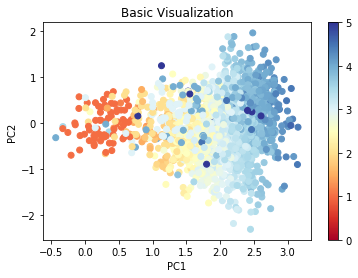

array([[ 2.705298  ,  2.06127198,  1.90943446, ...,  0.43347805,
         1.00205531,  1.1301728 ],
       [-0.63144055, -0.49432   , -1.0244865 , ..., -0.29986281,
         0.35000714,  0.78039029]])

In [58]:
title = 'Basic Visualization'
visualize_2d(V.T, title)


## Off the Shelf Code:

In [42]:
import numpy as np
from scipy.sparse.linalg import svds

def off_train(M, N, Y):
    train_m = np.zeros((M,N))
    arr = np.arange(len(Y))

    for index in arr:
        i = Y[index, 0] - 1
        j = Y[index, 1] - 1
        Yij = Y[index,2]
        train_m[i][j] = Yij
        
    #U, s, V = svds(train_m, k = 20)
    U, s, V = np.linalg.svd(train_m)

    return U, s, V

In [43]:
U_off, Sigma, V_off = off_train(M, N, Y_train)
#U = np.matmul(U, np.diag(np.sqrt(Sigma)))
#V = np.matmul(np.diag(np.sqrt(Sigma)), V)

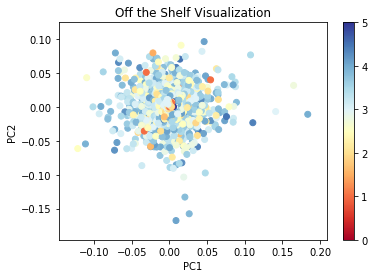

array([[ 3.19975166e-17, -6.81846868e-02,  7.63564244e-02, ...,
         2.49092379e-03, -4.92054703e-03, -1.94694697e-03],
       [ 1.02762037e-17,  1.69763209e-02,  3.23234102e-02, ...,
         3.67341793e-04,  6.49603545e-03,  3.95882009e-03]])

In [44]:
title = 'Off the Shelf Visualization'
visualize_2d(V_off.T, title)

In [35]:
#print(get_err(U, V, Y_train))
print(get_err(U, V, Y_test))

In [55]:
all_movies_names = []
with open('data/movies.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line_data = line.strip('\n').split('\t')
        all_movies_names.append(line_data[1])

def get_movie_names(index):
    chosen = []
    for i in index:
        chosen.append(all_movies_names[i])
    return chosen

In [ ]:
##ten random movies

ValueError: 'c' argument has 10 elements, which is not acceptable for use with 'x' with size 10, 'y' with size 10.

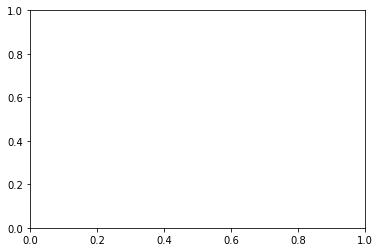

In [60]:
import random
    
num_movies = 1682
rand_index = np.random.choice(num_movies, 10, replace=False)
chosen_movie_names = get_movie_names(rand_index)
visualize_2d(V.T, rand_index, 8, names=chosen_movie_names)

In [ ]:
##ten most popular movies

In [ ]:
# index of top 10 by number of ratings
copy_num_rating = movie_num_user_rating.copy()
index_top10_popular = copy_num_rating.argsort()[-10:]
chosen_movie_names = get_movie_names(index_top10_popular)
for name in chosen_movie_names:
    print(name)
visualize_2d(V.T, index_top10_popular, 8, names=chosen_movie_names)

# maybe need to include genre??